In [1]:
import numpy as np
import torch
from torch import Tensor

from matplotlib import pyplot as plt

from ax.modelbridge.factory import get_GPEI, get_botorch
from ax.modelbridge.registry import Models, TorchModelBridge
from ax.models.torch.botorch import BotorchModel

from botorch.sampling import SobolQMCNormalSampler
from botorch.models.model import Model
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition import get_acquisition_function
from botorch.acquisition.objective import ConstrainedMCObjective
from botorch.utils import get_objective_weights_transform, get_outcome_constraint_transforms

from ax import (
    Data,
    Metric,
    Experiment,
    Objective,
    OutcomeConstraint,
    OptimizationConfig,
    ComparisonOp,
    ParameterType, 
    RangeParameter,
    SearchSpace, 
    OutcomeConstraint
)

from ax.plot.exp_utils import exp_to_df
from ax.service.utils.best_point import get_best_parameters

from albo.objective import ClassicAlboMCObjective
from albo.acquisition import AlboAcquisitionFactory
from albo.utils import get_untransformed_trace

### Toy problem from Gramacy et. al

In [2]:
def gramacy(x):
    """Gramacy problem function
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    f = x1 + x2
    c1 = (3./2) - x1 - 2.*x2 - (1./2) * np.sin(2. * np.pi * (x1**2 - 2.*x2))
    c2 = x1**2 + x2**2 - 3./2
    return np.stack([f, c1, c2], axis=1)

bounds = np.array([[0.0, 0.0], [1.0, 1.0]])

In [3]:
def make_feasibility_plot_2d(
    ax,
    fcn,
    bounds,
    nx: int = 100,
    ny: int = 100,
    levels=None,
    levels_fmt='%2.1f'
):
    x_bounds = bounds[:, 0]
    x = np.linspace(x_bounds[0], x_bounds[1], num=nx)

    y_bounds = bounds[:, 1]
    y = np.linspace(y_bounds[0], y_bounds[1], num=ny)

    x_grid, y_grid = np.meshgrid(x, y)
    x_ = x_grid.flatten()
    y_ = y_grid.flatten()

    X = np.stack((x_, y_), axis=1)
    Z = fcn(X)
    
    contours = list()
    for i in range(Z.shape[1]):
        c = Z[:, i]
        c_grid = c.reshape((len(x), len(y)))

        if i > 0:
            cfill = ax.contourf(x_grid, y_grid, c_grid, levels=[0.0, np.inf], colors='lightgray')
            clines = ax.contour(x_grid, y_grid, c_grid, levels=[0.0])
            contours.append((cfill, clines))
        else:
            clines = ax.contour(x_grid, y_grid, c_grid, levels=levels)
            ax.clabel(clines, fmt=levels_fmt, colors='k')
            contours.append((clines))

    return contours

Lets visualize Gramacy toy problem. The objective function is shown by level sets, and the feasible region is not shaded. There three local optima and the location of global optimum is shown by the red marker.

Text(0, 0.5, 'y')

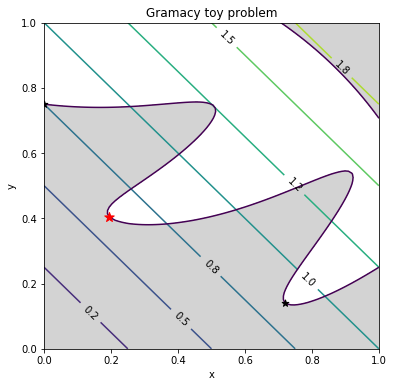

In [4]:
fh = plt.figure(figsize=[6, 6])
axes = fh.subplots()
contours = make_feasibility_plot_2d(axes, gramacy, bounds)
local_optimizers = {'x': [0.1954, 0.7197, 0.0], 'y': [0.4044, 0.1411, 0.75]}
f_opt = 0.599788
axes.scatter(local_optimizers['x'], local_optimizers['y'], marker='*', zorder=10, color='k', s=50)
axes.scatter(local_optimizers['x'][:1], local_optimizers['y'][:1], marker='*', zorder=10, color='r', s=100)
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
axes.set_title('Gramacy toy problem')
axes.set_xlabel('x')
axes.set_ylabel('y')

### Setup optimization problem for AX

In [5]:
def gramacy_evaluation_fcn(parametrization):
    """Evaluation function for Gramacy problem
    """
    x = parametrization.get('x')
    y = parametrization.get('y')
    X = np.array([[x, y]])
    z = gramacy(X)
    
    return {
        'f': (z[0, 0], 0.0), 
        'c1': (z[0, 1], 0.0), 
        'c2': (z[0, 2], 0.0)
    }

# def get_evaluations(arms):
#     return {arm.name: gramacy_evaluation_fcn(arm.parameters) for arm in arms}

search_space = SearchSpace(
    parameters=[
        RangeParameter(name='x', parameter_type=ParameterType.FLOAT, lower=0.0, upper=1.0),
        RangeParameter(name='y', parameter_type=ParameterType.FLOAT, lower=0.0, upper=1.0)
    ]
)

objective = Objective(metric=Metric(name='f'), minimize=True)
constraint1 = OutcomeConstraint(metric=Metric(name='c1'), op=ComparisonOp.LEQ, bound=0.0, relative=False)
constraint2 = OutcomeConstraint(metric=Metric(name='c2'), op=ComparisonOp.LEQ, bound=0.0, relative=False)

optimization_config = OptimizationConfig(
    objective=objective, 
    outcome_constraints=[
        constraint1, 
        constraint2
    ]
)

### Setup experiment with ALBO objective


Create a new experiment

In [6]:
def create_experiment(name=None):
    return Experiment(
        name=name,
        search_space=search_space,
        optimization_config=optimization_config
    )

Use a randomized policy for initial exploration

In [7]:
def random_init(exp, n=5):
    sobol = Models.SOBOL(search_space=exp.search_space)
    gr = sobol.gen(n=n)
    trial = exp.new_batch_trial()
    trial.add_arms_and_weights(gr.arms)
    trial.mark_running(no_runner_required=True)
    evaluations = {arm.name: gramacy_evaluation_fcn(arm.parameters) for arm in trial.arms}
    data = Data.from_evaluations(evaluations, trial.index)
    exp.attach_data(data)
    trial.mark_completed()

Next we use ALBO objective to guide optimization. In the first phase we use `qExpectedImprovement` acquisition function to balance exploration and exploitation. In the second phase we turn to pure exploitation with `qSimpleRegret`. At this step ALBO objective helps to drill down to the edge of the feasible region.

In [8]:
def get_albo_acqf_constructor(acqf_name="qEI", penalty_rate=10.0, num_iter_inner=10, **kw):
    # Using classical penalty function 
    albo_objective_constructor = ClassicAlboMCObjective
        
    # number of mults should be equal to number of constraints
    init_mults = torch.tensor([1.0, 1.0], dtype=torch.double)
    bounds = torch.tensor([[0.0, 0.0], [1.0, 1.0]], dtype=torch.double)
    
    return AlboAcquisitionFactory(
        albo_objective_constructor=albo_objective_constructor,
        acquisition_function_name=acqf_name,
        bounds=bounds,
        init_mults=init_mults,
        init_penalty_rate=penalty_rate,
        num_iter=num_iter_inner,
        num_restarts=32
    )

Compare to ConstrainedMCObjective 

In [9]:
class CmcoAcquisitionConstructor(object):
    def __init__(self, acqf_name, eta=0.0001, infeasible_cost=0.0):
        self.acqf_name = acqf_name
        self.eta = eta
        self.infeasible_cost = infeasible_cost
        
    def __call__(self, model, objective_weights, outcome_constraints, X_observed, **kw):
        objective_callable = get_objective_weights_transform(objective_weights)
        constaints_callable_list = get_outcome_constraint_transforms(outcome_constraints)
        objective = ConstrainedMCObjective(
            objective=objective_callable,
            constraints=constaints_callable_list,
            eta=self.eta,
            infeasible_cost=self.infeasible_cost
            
        )
        acqf = get_acquisition_function(self.acqf_name, model, objective, X_observed)
        return acqf

def get_cmco_acqf_constructor(acqf_name="qEI", eta=0.0001, infeasible_cost=0.0, **kwargs):
    cmco_acqf_constructor= CmcoAcquisitionConstructor(acqf_name, eta, infeasible_cost)
    return cmco_acqf_constructor

In [79]:
def get_best_feasible_point(experiment, tol=0.0):
    """Find best feasible arm
    """
    df = exp_to_df(experiment)
    df['u'] = np.where(np.logical_and(df['c1'] < tol, df['c2'] < tol), df['f'], np.inf).astype(np.float)
    best_row = df.loc[df['u'].idxmin()]
    trial_index = best_row['trial_index']
    arm_name = best_row['arm_name']
    f = best_row['f']
    c1 = best_row['c1']
    c2 = best_row['c2']
    return dict(trial_index=trial_index, arm_name=arm_name, f=f, c1=c1, c2=c2)

Main optimization loop

In [20]:
def optimize(exp, steps, verbose=True):  
    for step in steps:  
        for i in range(step['num_iter']):
            # Create instance of acquisition function over ALBO objective
            if step['method'] == 'ALBO':
                acqf_constructor = get_albo_acqf_constructor(**step['params'])
            elif step['method'] == 'CMCO':
                acqf_constructor = get_cmco_acqf_constructor(**step['params'])
            else:
                raise ValueError()

            # Create BoTorch model with a custom acquisition function 
            model = get_botorch(
                experiment=exp,
                search_space=search_space,
                data=exp.fetch_data(),
                acqf_constructor=acqf_constructor
            )

            generator_run = model.gen(1)
            trial = exp.new_batch_trial(generator_run=generator_run)
            trial.mark_running(no_runner_required=True)
            evaluations = {arm.name: gramacy_evaluation_fcn(arm.parameters) for arm in trial.arms}
            data = Data.from_evaluations(evaluations, trial.index)
            exp.attach_data(data)
            trial.mark_completed()
        
            # Print
            if verbose:
                print(
                    step['method'],
                    step['params']['acqf_name'],
                    i,
                    'candidate=(%f, %f)' % (trial.arms[0].parameters['x'], trial.arms[0].parameters['y'])
                )
    
    return model, acqf_constructor

## Run optimization experiment with ALBO objective

In [21]:
steps_albo = [
    {
        "method": "ALBO",
        "num_iter": 20,
        "params": {
            "acqf_name": "qEI",
            "penalty_rate": 10.0,
            "num_iter_inner": 10
        }
    },
    {
        "method": "ALBO",
        "num_iter": 5,
        "params": {
            "acqf_name": "qSR",
            "penalty_rate": 10.0,
            "num_iter_inner": 10
        }
    }
]

In [22]:
exp_albo = create_experiment(name="exp_albo")
random_init(exp_albo, n=5)
model, acqf_constructor = optimize(exp_albo, steps_albo, verbose=True)

ALBO qEI 0 candidate=(0.135049, 0.660429)
ALBO qEI 1 candidate=(0.000000, 0.346813)
ALBO qEI 2 candidate=(0.000000, 0.013278)
ALBO qEI 3 candidate=(0.000000, 0.397997)
ALBO qEI 4 candidate=(0.000000, 0.891644)
ALBO qEI 5 candidate=(0.065098, 0.384317)
ALBO qEI 6 candidate=(0.183092, 0.394454)
ALBO qEI 7 candidate=(0.242448, 0.371685)
ALBO qEI 8 candidate=(0.196348, 0.411222)
ALBO qEI 9 candidate=(0.167330, 0.410467)
ALBO qEI 10 candidate=(0.545056, 0.694581)
ALBO qEI 11 candidate=(0.195107, 0.403633)
ALBO qEI 12 candidate=(0.292173, 0.550984)
ALBO qEI 13 candidate=(0.369097, 0.014427)
ALBO qEI 14 candidate=(0.194756, 0.404617)
ALBO qEI 15 candidate=(0.934477, 0.549492)
ALBO qEI 16 candidate=(0.579775, 0.000000)
ALBO qEI 17 candidate=(0.195029, 0.404686)
ALBO qEI 18 candidate=(0.636381, 0.227951)
ALBO qEI 19 candidate=(0.010874, 0.630017)
ALBO qSR 0 candidate=(0.195048, 0.404730)
ALBO qSR 1 candidate=(0.195061, 0.404733)
ALBO qSR 2 candidate=(0.195047, 0.404733)
ALBO qSR 3 candidate=(0.

In [24]:
best_point = get_best_feasible_point(exp_albo)
best_arm = exp_albo.arms_by_name.get(best_point['arm_name'])
print ('Best feasible observed point', best_arm.parameters)
print ('Best feasible objective', '%f' % best_point['f'])
print ('Utility gap', '%f' % (best_point['f'] - f_opt))
print ('Constraints', 'c1=%f, c2=%f' % (best_point['c1'], best_point['c2']))

Best feasible observed point {'x': 0.19505459518275745, 'y': 0.40473528865244335}
Best feasible objective 0.599790
Utility gap 0.000002
Constraints c1=-0.000002, c2=-1.298143


View full optimization trace

In [25]:
exp_to_df(exp_albo).sort_values(by='trial_index').reset_index()

,index,arm_name,c1,c2,f,trial_index,x,y
0,0,0_0,0.536419,-1.20926,0.613797,0,8.066630e-02,5.331312e-01
1,1,0_1,1.31303,-1.37613,0.454742,0,3.285570e-01,1.261846e-01
2,2,0_2,-1.22789,-0.217504,1.6009,0,8.234596e-01,7.774383e-01
3,3,0_3,0.762245,-0.503132,1.06483,0,9.960616e-01,6.876890e-02
4,4,0_4,-1.38031,-0.350044,1.43361,0,4.694761e-01,9.641308e-01
5,7,1_0,0.517016,-1.0456,0.795477,1,1.350486e-01,6.604286e-01
6,19,2_0,0.337415,-1.37972,0.346813,2,5.355887e-16,3.468125e-01
7,23,3_0,1.55648,-1.49982,0.0132778,3,1.996823e-15,1.327778e-02
8,24,4_0,0.22474,-1.3416,0.397997,4,4.144331e-14,3.979966e-01
9,25,5_0,-0.772391,-0.704971,0.891644,5,1.859334e-16,8.916437e-01


To get the final values for Lagrange multipliers we need to untransform them from standardized space used by BoTorch model.

In [26]:
std_f = model.transforms['StandardizeY'].Ystd['f']
std_c1 = model.transforms['StandardizeY'].Ystd['c1']
std_c2 = model.transforms['StandardizeY'].Ystd['c1']
lagrange_mults = acqf_constructor.albo_objective.lagrange_mults
l1 = lagrange_mults[0].item() * std_f / std_c1
l2 = lagrange_mults[1].item() * std_f / std_c2
print('Lagrange multipliers: lamdba1 = %f, lambda2 =  %f' % (l1, l2))

Lagrange multipliers: lamdba1 = 0.867981, lambda2 =  0.000000


## Experiment with ConstrainedMCObjective

In [27]:
steps_cmco = [
    {
        "method": "CMCO",
        "num_iter": 20,
        "params": {
            "acqf_name": "qEI",
            "penalty_rate": 10.0,
            "num_iter_inner": 10
        }
    },
    {
        "method": "CMCO",
        "num_iter": 5,
        "params": {
            "acqf_name": "qSR",
            "penalty_rate": 10.0,
            "num_iter_inner": 10
        }
    }
]

In [28]:
exp_cmco = create_experiment(name="exp")
random_init(exp_cmco, n=5)
model, acqf_constructor = optimize(exp_cmco, steps_cmco, verbose=True)

CMCO qEI 0 candidate=(0.000000, 0.833001)
CMCO qEI 1 candidate=(0.000000, 0.744875)
CMCO qEI 2 candidate=(0.000000, 0.001382)
CMCO qEI 3 candidate=(0.998297, 0.000000)
CMCO qEI 4 candidate=(0.000000, 0.754823)
CMCO qEI 5 candidate=(0.000000, 0.750145)
CMCO qEI 6 candidate=(0.501403, 0.000000)
CMCO qEI 7 candidate=(0.652620, 0.000000)
CMCO qEI 8 candidate=(0.217461, 0.459918)
CMCO qEI 9 candidate=(0.000000, 0.447142)
CMCO qEI 10 candidate=(0.225021, 0.462090)
CMCO qEI 11 candidate=(0.161183, 0.485380)
CMCO qEI 12 candidate=(0.208825, 0.422437)
CMCO qEI 13 candidate=(0.198603, 0.410623)
CMCO qEI 14 candidate=(0.194730, 0.407152)
CMCO qEI 15 candidate=(0.182067, 0.412845)
CMCO qEI 16 candidate=(0.944026, 0.341146)
CMCO qEI 17 candidate=(0.245038, 0.000000)
CMCO qEI 18 candidate=(0.007973, 0.354493)
CMCO qEI 19 candidate=(0.221478, 0.367710)
CMCO qSR 0 candidate=(0.194174, 0.406425)
CMCO qSR 1 candidate=(0.194228, 0.406184)
CMCO qSR 2 candidate=(0.194281, 0.406053)
CMCO qSR 3 candidate=(0.

In [30]:
best_point = get_best_feasible_point(exp_cmco)
best_arm = exp_cmco.arms_by_name.get(best_point['arm_name'])
print ('Best feasible observed point', best_arm.parameters)
print ('Best feasible objective', '%f' % best_point['f'])
print ('Utility gap', '%f' % (best_point['f'] - f_opt))
print ('Constraints', 'c1=%f, c2=%f' % (best_point['c1'], best_point['c2']))

Best feasible observed point {'x': 0.19441869126689568, 'y': 0.40583891361041025}
Best feasible objective 0.600258
Utility gap 0.000470
Constraints c1=-0.000479, c2=-1.297496


/home/stys/anaconda3/envs/albo/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)



## Repeated experiments for many runs

In [ ]:
n_runs = 100
exps_albo = []
exps_cmco = []
for i in range(n_runs):
    print(i)
    
    exp_albo = create_experiment(name="exp_albo")
    random_init(exp_albo, n=5)
    optimize(exp_albo, steps_albo, verbose=False)
    exps_albo.append(exp_albo)
    
    exp_cmco = create_experiment(name="exp_cmco")
    random_init(exp_cmco, n=5)
    optimize(exp_cmco, steps_cmco, verbose=False)
    exps_cmco.append(exp_cmco)

Plot results of optimization

In [98]:
def plot_trace_median(ax, exps, n_iter_total, tol=0.0, label=None):
    n_runs = len(exps)
    u = np.zeros((n_runs, n_iter_total))
    for i, exp in enumerate(exps):
        df = exp_to_df(exp)
        u[i, :] = np.minimum.accumulate(np.where(np.logical_and(df['c1'] < tol, df['c2'] < tol), df['f'] - f_opt, 100))
    u_median = np.median(u, axis=0)
    every_3_1 = np.array(list((x + 1) % 2 == 0 for x in range(n_iter_total)))
    u_q75 = np.where(every_3_1, np.quantile(u, 0.75, 0), 0)
    u_q25 = np.where(every_3_1, np.quantile(u, 0.25, 0), 0)
    ax1.errorbar(
        np.arange(n_iter_total) + 1,
        u_median,
        np.array([u_median - u_q25, u_q75 - u_median]),
        linewidth=3,
        elinewidth=1,
        capsize=3,
        label=label
    )
    ax1.set_yscale('log')
    ax1.grid()
    ax1.set_title('Utility gap')
    ax1.set_xlim([0, n_iter_total])
    ax1.set_xlabel('iterations')
    
    
def plot_scatter_best(ax, exps, tol=0.0): 
    n_runs = len(exps)
    best_feasible_points = np.zeros((n_runs, 2))
    for i, exp in enumerate(exps):
        best_point = get_best_feasible_point(exp, tol)
        bp = exp.arms_by_name.get(best_point['arm_name']).parameters
        best_feasible_points[i, :] = np.array([bp['x'], bp['y']])    
    ax.scatter(best_feasible_points[:, 0], best_feasible_points[:, 1], zorder=10, c='b', s=3)

Text(0.5, 1.0, 'Best feasible point, CMCO')

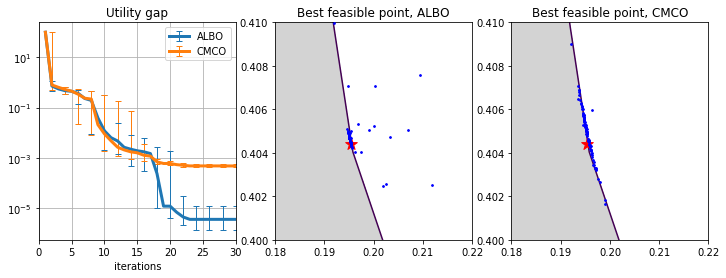

In [102]:
fh = plt.figure(figsize=[12, 4])
ax1, ax2, ax3 = fh.subplots(1, 3)

plot_trace_median(ax1, exps_albo, n_iter_total=30, label='ALBO')
plot_trace_median(ax1, exps_cmco, n_iter_total=30, label='CMCO')
ax1.legend()
ax1.grid()

contours2 = make_feasibility_plot_2d(ax2, gramacy, bounds=bounds)
ax2.scatter(local_optimizers['x'][:1], local_optimizers['y'][:1], marker='*', zorder=10, color='r', s=150)
plot_scatter_best(ax2, exps_albo)
ax2.set_xlim([0.18, 0.22])
ax2.set_ylim([0.40, 0.41])
ax2.set_title('Best feasible point, ALBO')

contours3 = make_feasibility_plot_2d(ax3, gramacy, bounds=bounds)
ax3.scatter(local_optimizers['x'][:1], local_optimizers['y'][:1], marker='*', zorder=10, color='r', s=150)
plot_scatter_best(ax3, exps_cmco)
ax3.set_xlim([0.18, 0.22])
ax3.set_ylim([0.40, 0.41])
ax3.set_title('Best feasible point, CMCO')